# Exercise 3 - Júlia Tartera

Let us consider a detector that measures the energy $ E$ of particles in the range from 0 to 100
(arbitrary units).
The pdf of $E$ for signal particles is given by

$$
f (E | E_0, \sigma) = \frac{1}{\sqrt{2 \pi\sigma}} \exp{-\frac{(E-E_0)^2}{2\sigma^2}}
$$
i.e. Gaussian with $\mu = E_0$ and $\sigma$.

We normalize the pdf in the range used for the problem:

$$
1 = N \int_0^{100}\  f (E | E_0, \sigma) \ dE \quad \Rightarrow \quad N = \frac{1}{F(100)-F(0)}
$$
with $ F(x)$ being the cumulative distribution function.


The measurement is affected by background particles (i.e. the detector cannot distinguish them
from signal particles) distributed uniformly in the same energy range. Hence

$$
u (E) = \kappa \quad \Rightarrow \quad 1 = \int_0^{100} u (E)   d E \quad \Rightarrow \quad u(E) = \frac{1}{100} \quad \text{for}\quad E = [0,100]

$$


Let I denote the mean fraction of signal particles in the sample. The total pdf of measured
energies is then

$$
p (E | I, E_0, \sigma) = k \big(I f (E | E_0, \sigma)+ (1-I) u (E) \big)
$$

where $k$ the normalization factor is

$$
1 = \int_0^{100}\  p (E | I, E_0, \sigma) \ dE = kI \int_0^{100} f (E | E_0, \sigma) \ dE +  k(1-I) \int_0^{100}  u (E) \  dE = k I + k (1-I) \quad \Rightarrow \quad k = 1
$$

The set of hypothesis are:
- $H_0$: $I_\text{true} = 0.3$, $E_{0,\text{true}} = 40$, $\sigma_\text{true} = 10$
- $H_I$: $I_\text{true} = 0.99$, $E_{0,\text{true}} = 60$, $\sigma_\text{true} = 2$

with $E_0$ and $\sigma$ unconstrained nuissance parameters.

The log-likelihood is

$$
\log L (I, E_0, \sigma) = \sum_{i=1}^{n=100} \log\big( I f (E | E_0, \sigma)+ (1-I) u (E)\big)
$$

and we must maximize it to find the estimators $\hat I, \ \hat E_0,\  \hat \sigma$.

Then compute the profile likelihood ratio as

$$
\lambda_p = \frac{L (I= 0.3 , \hat E_0, \hat \sigma)}{L (\hat I, \hat E_0, \hat \sigma)}

$$

and 

$$
-2 \log \lambda_p = -2 [\log L (I=0.3, E_0, \sigma) - \log L (I, E_0, \sigma) ]

$$

Wilk's theorem states that for large n
$$
-2 \log \lambda_p \sim \chi ^2 (m)
$$
with $m$ the number of difference between number of degrees of freedom of H1 and H0 that in this case is one.


In [15]:
#--------------------------------------------
#Import necessary libraries
#--------------------------------------------   
import numpy as np
from scipy.optimize import minimize
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import chi2, kstest, truncnorm


In [ ]:
#--------------------------
#Define the pdf
#--------------------------

def signal_pdf(E, E0, sig):
    # Truncated normal between 0 and 100
    a, b = (0 - E0) / sig, (100 - E0) / sig
    return truncnorm.pdf(E, a, b, loc=E0, scale=sig)

def background_pdf(E):
    return np.ones_like(E) / 100

def background_pdf(E):
    return np.ones_like(E) / 100

def total_pdf(E, I, E0, sig):
    return I * signal_pdf(E,E0,sig) + (1-I) * background_pdf(E)


#-----------------------------------------------
# --------------------------
# Define the pdfs
# --------------------------
def signal_pdf(E, E0, sig):
    # Truncated normal between 0 and 100
    a, b = (0 - E0) / sig, (100 - E0) / sig
    return truncnorm.pdf(E, a, b, loc=E0, scale=sig)

def background_pdf(E):
    return np.ones_like(E) / 100

def total_pdf(E, I, E0, sig):
    return I * signal_pdf(E, E0, sig) + (1 - I) * background_pdf(E)


In [23]:
#---------------------------------------------------------------
#Define the function for the log-ikelihood and for ML estimators
#---------------------------------------------------------------

def neg_logL(params, data, Ifixed=False, Ivalue=None):
    if Ifixed:
        I = Ivalue
        E0, sigma = params
    else:
        I, E0, sigma = params

    pdf_vals = total_pdf(data, I, E0, sigma)
    pdf_vals = np.clip(pdf_vals, 1e-12, None)  # avoid log(0)
    nll = -np.sum(np.log(pdf_vals))
    return nll


def MLestimator(data, initial_params, Ifixed=False, Ivalue=None):
    if Ifixed:
        bounds = [(0, 100), (1e-3, None)]  # E0, sigma
        args = (data, True, Ivalue)
    else:
        bounds = [(1e-6, 0.9999), (0, 100), (1e-3, None)]  # I, E0, sigma
        args = (data, False, None)

    result = minimize(
        neg_logL, initial_params, args=args,
        bounds=bounds, method='L-BFGS-B', options={'ftol':1e-10, 'gtol':1e-10}
    )

    if not result.success:
        print("⚠️ Optimization failed:", result.message)
    return result.x


In [30]:
#---------------------------------------------------------------
#Function to obtain the distribution of the test statistic under H0
#---------------------------------------------------------------
        
def obtain_lambdas(Nsim, Itrue, E0, sigma, n_measurements, seed=None):
    if seed is not None:
        np.random.seed(seed)

    lambdas = []
    params_null = (Itrue, E0, sigma)
    params_one = (E0, sigma)

    for _ in range(Nsim):

        is_signal = np.random.rand(n_measurements) < Itrue
        n_sig = np.sum(is_signal)
        n_bkg = n_measurements - n_sig

        a, b = (0 - E0) / sigma, (100 - E0) / sigma
        energies = np.empty(n_measurements)
        energies[is_signal] = truncnorm.rvs(a, b, loc=E0, scale=sigma, size=n_sig)
        energies[~is_signal] = np.random.uniform(0, 100, n_bkg)


        estimator_null = MLestimator(energies, params_null, Ifixed=False, Ivalue=None)
        estimator_one = MLestimator(energies, params_one, Ifixed=True, Ivalue=Itrue)


        loglikelihood_null = -neg_logL(estimator_null, energies, Ifixed=False, Ivalue=None)
        loglikelihood_one = -neg_logL(estimator_one, energies, Ifixed=True, Ivalue=Itrue)

        lambdas.append(-2 * (loglikelihood_one - loglikelihood_null))

    return np.array(lambdas)



In [44]:
Nsim = 1000

# --------------------------
# Example: Itrue = 0.3
# --------------------------

lambda_03_1000 = obtain_lambdas(Nsim, Itrue=0.3, E0=40, sigma=10, n_measurements=1000)
lambda_03_100  = obtain_lambdas(Nsim,  Itrue=0.3, E0=40, sigma=10, n_measurements=100)
statistic, pvalue = kstest(lambda_03_1000, chi2(df=1).cdf)
print('Hypothesis test for Itrue=0.3 with Nsim=1000')
print("KS Statistic:", statistic)
print("p-value:", pvalue)
statistic, pvalue = kstest(lambda_03_100, chi2(df=1).cdf)
print('Hypothesis test for Itrue=0.3 with Nsim=100')
print("KS Statistic:", statistic)
print("p-value:", pvalue)

# --------------------------
# Example: Itrue = 0.99
# --------------------------

lambda_99_1000 = obtain_lambdas(Nsim, Itrue=0.99, E0=60, sigma=2, n_measurements=1000)
statistic, pvalue = kstest(lambda_99_1000, chi2(df=1).cdf)
print('Hypothesis test for Itrue=0.99 with Nsim=1000')
print("KS Statistic:", statistic)
print("p-value:", pvalue)

lambda_99_100 = obtain_lambdas(Nsim, Itrue=0.99, E0=60, sigma=2, n_measurements=100)
statistic, pvalue = kstest(lambda_99_100, chi2(df=1).cdf)
print('Hypothesis test for Itrue=0.99 with Nsim=100')
print("KS Statistic:", statistic)
print("p-value:", pvalue)

⚠️ Optimization failed: ABNORMAL: 
⚠️ Optimization failed: ABNORMAL: 
⚠️ Optimization failed: ABNORMAL: 
⚠️ Optimization failed: ABNORMAL: 
Hypothesis test for Itrue=0.3 with Nsim=1000
KS Statistic: 0.017912760216940604
p-value: 0.8994977767019364
Hypothesis test for Itrue=0.3 with Nsim=100
KS Statistic: 0.08551830864467691
p-value: 8.221409648797137e-07
Hypothesis test for Itrue=0.99 with Nsim=1000
KS Statistic: 0.0410528316990329
p-value: 0.06684002697873948
⚠️ Optimization failed: ABNORMAL: 
Hypothesis test for Itrue=0.99 with Nsim=100
KS Statistic: 0.298543741330477
p-value: 1.596898592548642e-79


In [46]:
#---------------------------------------------------------------
#Function to perform the KS test
#---------------------------------------------------------------
def perform_KS_test(lambdas, df):
    D, p_value = kstest(lambdas, 'chi2', args=(df,))
    return D, p_value, p_value < 0.05
#apply the function


import pandas as pd
results = {
    'Itrue': [0.3, 0.3, 0.99, 0.99],
    'Nmeasurements': [1000, 100, 1000, 100],
    'KS Statistic D': [perform_KS_test(lambda_03_1000, df=1)[0],
                       perform_KS_test(lambda_03_100, df=1)[0],
                       perform_KS_test(lambda_99_1000, df=1)[0],
                       perform_KS_test(lambda_99_100, df=1)[0]],
    'p-value': [perform_KS_test(lambda_03_1000, df=1)[1],
                perform_KS_test(lambda_03_100, df=1)[1],
                perform_KS_test(lambda_99_1000, df=1)[1],
                perform_KS_test(lambda_99_100, df=1)[1]],
    'Reject H0 at 5%?': [perform_KS_test(lambda_03_1000, df=1)[2],
                        perform_KS_test(lambda_03_100, df=1)[2],
                        perform_KS_test(lambda_99_1000, df=1)[2],
                        perform_KS_test(lambda_99_100, df=1)[2]]
}

df_results = pd.DataFrame(results)
print(df_results)


   Itrue  Nmeasurements  KS Statistic D       p-value  Reject H0 at 5%?
0   0.30           1000        0.017913  8.994978e-01             False
1   0.30            100        0.085518  8.221410e-07              True
2   0.99           1000        0.041053  6.684003e-02             False
3   0.99            100        0.298544  1.596899e-79              True


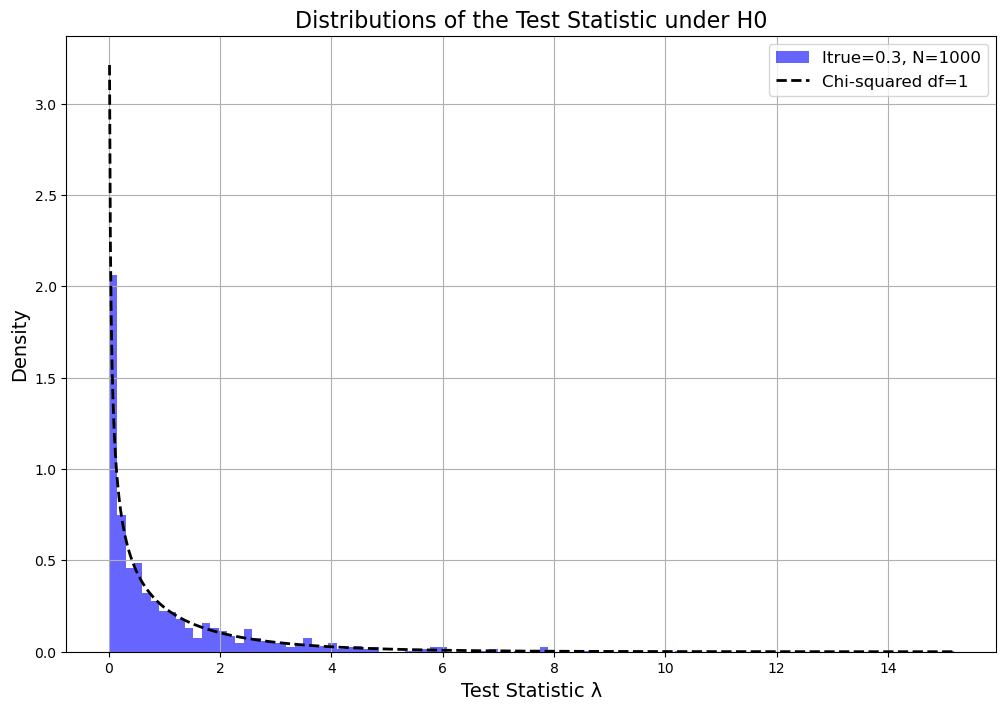

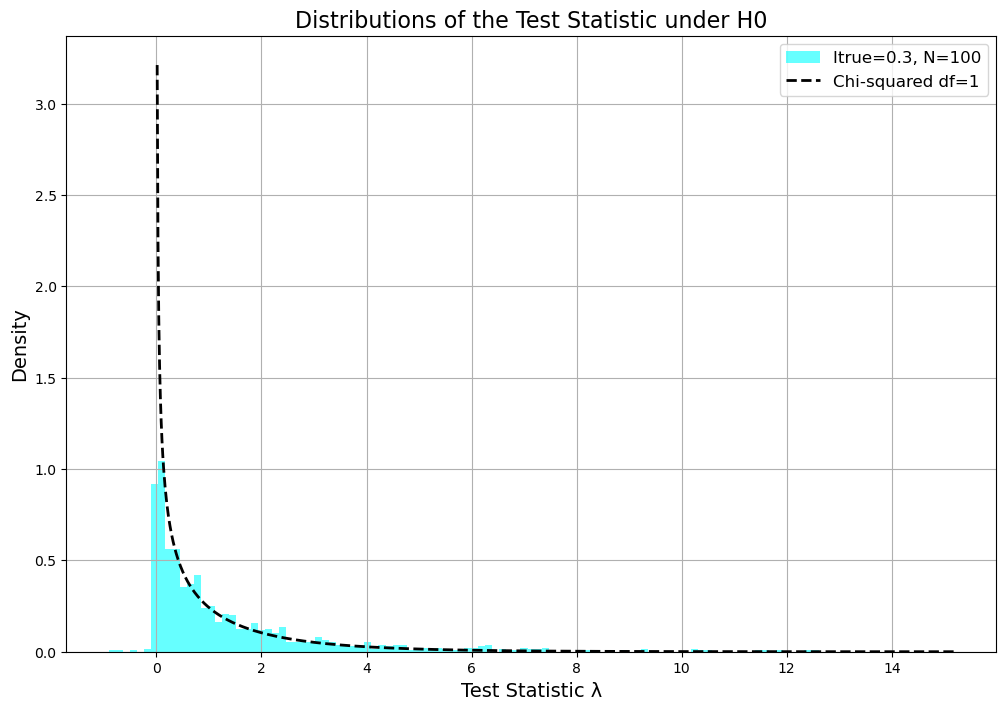

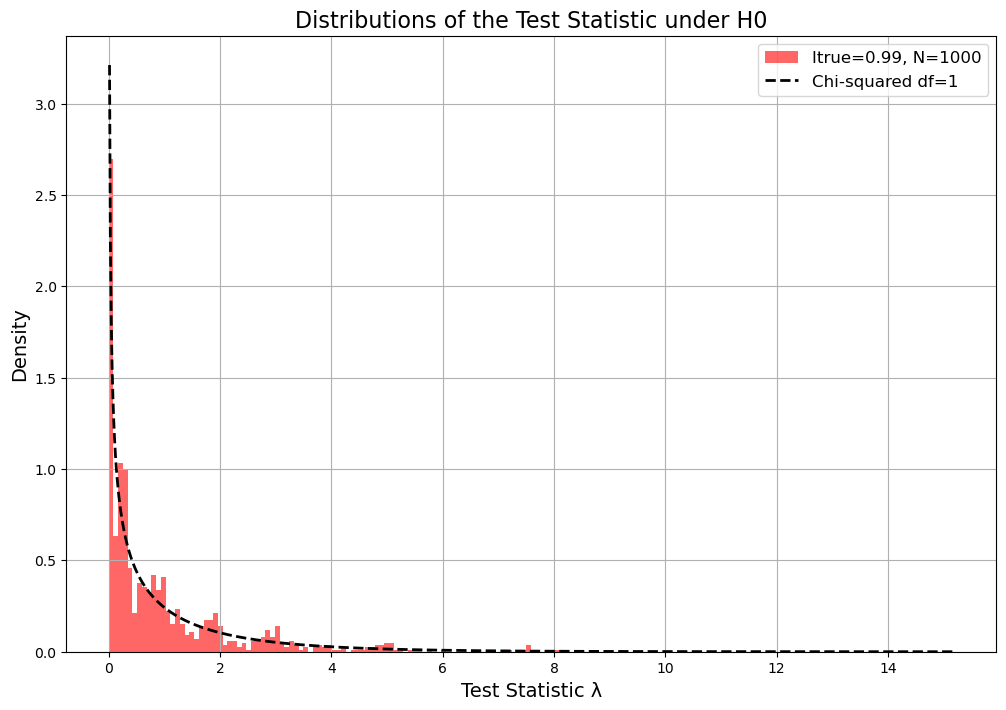

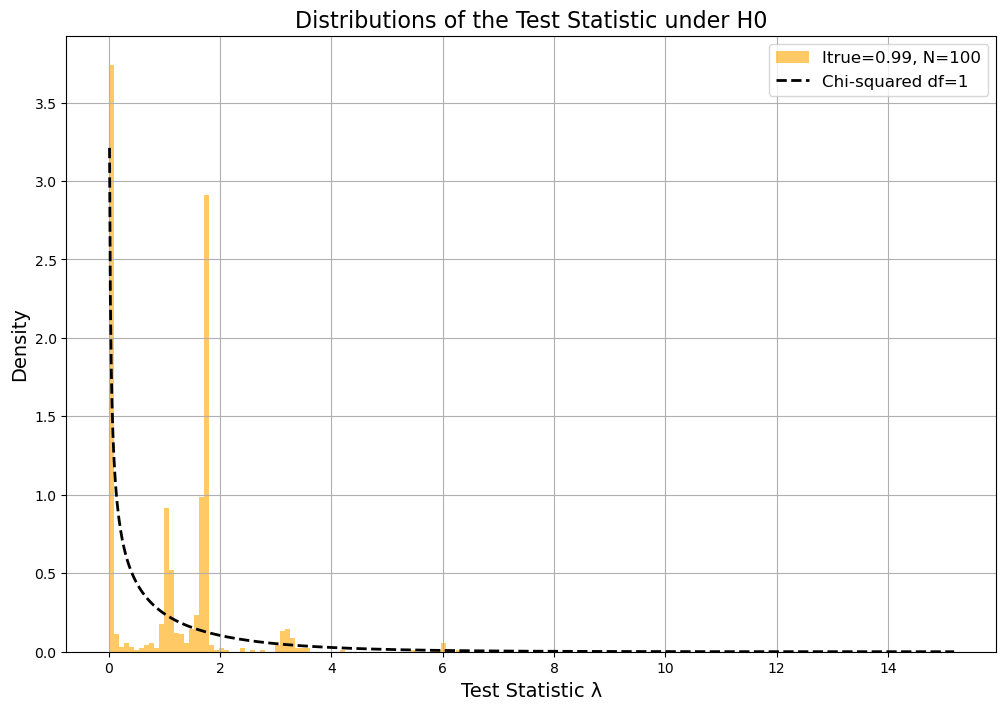

In [47]:
#---------------------------------------------------------------
#plot the distributions
#---------------------------------------------------------------

bins = 100
plt.figure(figsize=(12, 8))
plt.hist(lambda_03_1000, bins=bins, density=True, alpha=0.6, label='Itrue=0.3, N=1000', color='blue')


x = np.linspace(0, max(np.max(lambda_03_1000), np.max(lambda_99_1000)), 1000)
plt.plot(x, chi2.pdf(x, df=1), 'k--', label='Chi-squared df=1', linewidth=2)
plt.xlabel('Test Statistic λ', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distributions of the Test Statistic under H0', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()



plt.figure(figsize=(12, 8))
plt.hist(lambda_03_100, bins=bins, density=True, alpha=0.6, label='Itrue=0.3, N=100', color='cyan')

x = np.linspace(0, max(np.max(lambda_03_1000), np.max(lambda_99_1000)), 1000)
plt.plot(x, chi2.pdf(x, df=1), 'k--', label='Chi-squared df=1', linewidth=2)
plt.xlabel('Test Statistic λ', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distributions of the Test Statistic under H0', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()


plt.figure(figsize=(12, 8))
plt.hist(lambda_99_1000, bins=bins, density=True, alpha=0.6, label='Itrue=0.99, N=1000', color='red')


x = np.linspace(0, max(np.max(lambda_03_1000), np.max(lambda_99_1000)), 1000)
plt.plot(x, chi2.pdf(x, df=1), 'k--', label='Chi-squared df=1', linewidth=2)
plt.xlabel('Test Statistic λ', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distributions of the Test Statistic under H0', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()

plt.figure(figsize=(12, 8))

plt.hist(lambda_99_100, bins=bins, density=True, alpha=0.6, label='Itrue=0.99, N=100', color='orange')

x = np.linspace(0, max(np.max(lambda_03_1000), np.max(lambda_99_1000)), 1000)
plt.plot(x, chi2.pdf(x, df=1), 'k--', label='Chi-squared df=1', linewidth=2)
plt.xlabel('Test Statistic λ', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distributions of the Test Statistic under H0', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()







In [ ]:
import numpy as np
from scipy.stats import norm, rv_discrete, uniform, chi2, kstest
from scipy.optimize import minimize

# --------------------------
# Global settings
# --------------------------
XMIN = 0
XMAX = 100
PREC = 0.1

# --------------------------
# PDF definitions
# --------------------------
def signal_pdf(E, E0, sig):
    # Truncated normal using truncated CDF normalization
    a, b = (XMIN - E0) / sig, (XMAX - E0) / sig
    from scipy.stats import truncnorm
    return truncnorm.pdf(E, a, b, loc=E0, scale=sig)

def background_pdf(E):
    return np.ones_like(E) / (XMAX - XMIN)

def total_pdf(E, I, E0, sig):
    return I * signal_pdf(E, E0, sig) + (1 - I) * background_pdf(E)

# --------------------------
# Negative log-likelihood
# --------------------------
def neg_logL(params, data, Ifixed=False, Ivalue=None):
    if Ifixed:
        I = Ivalue
        E0, sigma = params
    else:
        I, E0, sigma = params

    pdf_vals = total_pdf(data, I, E0, sigma)
    pdf_vals = np.clip(pdf_vals, 1e-12, None)  # avoid log(0)
    return -np.sum(np.log(pdf_vals))

# --------------------------
# Maximum Likelihood Estimator
# --------------------------
def MLestimator(data, initial_params, Ifixed=False, Ivalue=None):
    if Ifixed:
        bounds = [(XMIN, XMAX), (1e-3, None)]  # E0, sigma
        args = (data, True, Ivalue)
    else:
        bounds = [(1e-6, 0.9999), (XMIN, XMAX), (1e-3, None)]  # I, E0, sigma
        args = (data, False, None)

    result = minimize(
        neg_logL, initial_params, args=args,
        bounds=bounds, method='L-BFGS-B',
        options={'ftol':1e-10, 'gtol':1e-10}
    )

    if not result.success:
        print("⚠️ Optimization failed:", result.message)
    return result.x

# --------------------------
# Data generation
# --------------------------
def generate_signal_samples(MU, SIGMA, Nsig):
    xval = np.arange(XMIN, XMAX, PREC)
    pval = norm.pdf(xval, MU, SIGMA)
    pval /= np.sum(pval)
    custom_dist = rv_discrete(name='custom_dist', values=(xval, pval))
    return custom_dist.rvs(size=Nsig)

def generate_background_samples(Nbg):
    return np.random.uniform(XMIN, XMAX, Nbg)

def generate_dataset(Itrue, MU, SIGMA, Nmeasurements):
    n_sig = int(Itrue * Nmeasurements)
    n_bg  = Nmeasurements - n_sig

    signal = generate_signal_samples(MU, SIGMA, n_sig)
    background = generate_background_samples(n_bg)
    data = np.concatenate([signal, background])
    np.random.shuffle(data)
    return data



def generate_dataset(Itrue, MU, SIGMA, Nmeasurements):

    # Decide per event if it's signal or background
    is_signal = np.random.rand(Nmeasurements) < Itrue
    n_sig = np.sum(is_signal)
    n_bg  = Nmeasurements - n_sig

    # Signal: discrete truncated Gaussian
    xval = np.arange(XMIN, XMAX, PREC)
    pval = norm.pdf(xval, MU, SIGMA)
    pval /= np.sum(pval)
    custom_dist = rv_discrete(name='custom_dist', values=(xval, pval))
    signal = custom_dist.rvs(size=n_sig)

    # Background: uniform
    background = np.random.uniform(XMIN, XMAX, n_bg)

    # Combine and shuffle
    data = np.empty(Nmeasurements)
    data[is_signal] = signal
    data[~is_signal] = background
    np.random.shuffle(data)
    return data

# --------------------------
# Monte Carlo: compute lambdas
# --------------------------
def obtain_lambdas(datasets, Itrue):
    lambdas = []
    for data in datasets:
        E0_init = np.mean(data)
        sigma_init = np.std(data)
        I_init = max(min(Itrue, 0.9999), 1e-6)

        estimator_null = MLestimator(data, (I_init, E0_init, sigma_init), Ifixed=False, Ivalue=None)
        estimator_one  = MLestimator(data, (E0_init, sigma_init), Ifixed=True, Ivalue=Itrue)

        logL_null = -neg_logL(estimator_null, data, Ifixed=False, Ivalue=None)
        logL_one  = -neg_logL(estimator_one,  data, Ifixed=True, Ivalue=Itrue)

        lambdas.append(-2 * (logL_one - logL_null))
    return np.array(lambdas)

# --------------------------
# Example workflow
# --------------------------
def monte_carlo_experiment(Itrue, MU, SIGMA, Nmeasurements=1000, Nsim=1000, seed=None):

    if seed is not None:
        np.random.seed(seed)

    datasets = np.zeros((Nsim, Nmeasurements))

    

    for i in range(Nsim):
        datasets[i] = generate_dataset(Itrue, MU, SIGMA, Nmeasurements)


    # Step 2: compute lambdas
    lambdas = obtain_lambdas(datasets, Itrue)

    # Step 3: KS test vs chi2
    statistic, pvalue = kstest(lambdas, chi2(df=1).cdf)
    return lambdas, statistic, pvalue

# --------------------------
# Run experiments
# --------------------------
if __name__ == "__main__":
    # I = 0.3
    lambdas_03_1000, stat_03_1000, p_03_1000 = monte_carlo_experiment(0.3, 40, 10, Nmeasurements=1000, Nsim=1000, seed=42)
    print("Itrue=0.3, N=1000 -> KS =", stat_03_1000, ", p-value =", p_03_1000)

    # I = 0.99
    lambdas_99_1000, stat_99_1000, p_99_1000 = monte_carlo_experiment(0.99, 60, 2, Nmeasurements=1000, Nsim=1000, seed=42)
    print("Itrue=0.99, N=1000 -> KS =", stat_99_1000, ", p-value =", p_99_1000)


⚠️ Optimization failed: ABNORMAL: 
⚠️ Optimization failed: ABNORMAL: 
⚠️ Optimization failed: ABNORMAL: 
Itrue=0.3, N=1000 -> KS = 0.02318785480422056 , p-value = 0.6466174164554809
Itrue=0.99, N=1000 -> KS = 0.06126885772550872 , p-value = 0.0010488172482746388


In [9]:
if __name__ == "__main__":
    # I = 0.3
    lambdas_03_100, stat_03_100, p_03_100 = monte_carlo_experiment(0.3, 40, 10, Nmeasurements=100, Nsim=1000, seed=42)
    print("Itrue=0.3, N=100 -> KS =", stat_03_100, ", p-value =", p_03_100)

    # I = 0.99
    lambdas_99_100, stat_99_100, p_99_100 = monte_carlo_experiment(0.99, 60, 2, Nmeasurements=100, Nsim=1000, seed=42)
    print("Itrue=0.99, N=100 -> KS =", stat_99_100, ", p-value =", p_99_100)


⚠️ Optimization failed: ABNORMAL: 
⚠️ Optimization failed: ABNORMAL: 
Itrue=0.3, N=100 -> KS = 0.04545717447095543 , p-value = 0.031090064971979525
⚠️ Optimization failed: ABNORMAL: 
Itrue=0.99, N=100 -> KS = 0.3005108098767454 , p-value = 1.3657500319766275e-80


In [10]:


results = {
    'Itrue': [0.3, 0.3, 0.99, 0.99],
    'Nmeasurements': [1000, 100, 1000, 100],
    'KS Statistic D': [stat_03_1000,
                       stat_03_100,
                       stat_99_1000,
                       stat_99_100],
    'p-value': [p_03_1000,
                p_03_100,
                p_99_1000,
                p_99_100],
    'Reject H0 at 5%?': [p_03_1000 < 0.05,
                        p_03_100 < 0.05,
                        p_99_1000 < 0.05,
                        p_99_100 < 0.05]
}

In [11]:
print(pd.DataFrame(results))

   Itrue  Nmeasurements  KS Statistic D       p-value  Reject H0 at 5%?
0   0.30           1000        0.023188  6.466174e-01             False
1   0.30            100        0.045457  3.109006e-02              True
2   0.99           1000        0.061269  1.048817e-03              True
3   0.99            100        0.300511  1.365750e-80              True
